# SST (Spatial Stress Test) fMRI Analysis

Data Collected June 2015

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
import ipywidgets
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

v2


### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['navdir'] = op.join('/Volumes/group/awagner/sgagnon/SST/nav_data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['navdir'], 'analysis', 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['navdir'], 'analysis','shortcut_coords.csv')
dirs['order_file'] = op.join(dirs['navdir'], 'analysis','SST_env_order.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

v2


### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info.group.value_counts()

stress     21
control    20
Name: group, dtype: int64

In [5]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,5,15
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,12,20,20,31
5,env6,24,40,24,40
6,env7,10,15,30,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


In [6]:
trial_order = pd.read_csv(dirs['order_file'])
trial_order[['subid']] = trial_order[['subid']].astype(str)
trial_order.tail()

,subid,rep,run,trial,env
1531,57,2,11,2,1
1532,57,2,11,3,6
1533,57,2,12,1,9
1534,57,2,12,2,5
1535,57,2,12,3,10


## Read in/concatenate data files

#### Only need to run this if first time:

In [7]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False
n_runs = 12

test_types = ['habit', 'shortcut']

# iterate through subjects
for subid in subj_info.subid:
# for subid in ['40']:
    print subid
    
    if test:
        d2 = pd.DataFrame() # dataframe of test files for a subj

        # iterate through environments
        for run_num in range(1, n_runs+1):

            # deal w/num -> str IDs
            if int(subid) < 10:
                sub_str = 'sst0'
            else:
                sub_str = 'sst'
                
            # add test file
            test_files = glob.glob(op.join(dirs['navdir'], sub_str + str(subid), 
                                           'run'+ str(run_num),
                                           'session_*', 'log.txt'))
            
            # get all files, including crashes where 2 files/run
            # note that grouping files into same run if a crash; 
            # this will be diff than for fmri data (where 2 sep runs)
            for i, test_file in enumerate(test_files):
                
                if i > 0: print '***** something happened, '+str(i+1)+' files for run ' +str(run_num)+'! *****'
                
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)

                d1 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d1['subid'] = subid
                d1['run'] = run_num

                if run_num < 5:
                    d1['type'] = 'habit'
                else:
                    d1['type'] = 'shortcut'

                # force time to in seconds, relative to beginning of session
                d1.time = d1.time.astype(int)/1000
                
                if (run_num == 1) & (i == 0):
                    session_start = d1.time.min()                
                d1.time = d1.time - session_start

                # Append to subj's dataframe
                d2 = d2.append(d1, ignore_index=True)
                

        d2 = d2.loc[d2.command.isin(['VROBJECT_POS', 'VROBJECT_HEADING', 'INPUT_EVENT',
                                     'ORIENT', 'ARRIVED', 'ASSIGNED', 'NAVIGATE', 
                                     'SCAN', 'SHOCK'])]
        d2.drop(['c2', 'c5', 'c6', 'c7', 'c8'], axis=1, inplace=True) #unneeded cols

        # Any runs without 3 trials?
        counts = pd.groupby(d2.loc[d2.command == "ORIENT"], by=['subid', 'run']).count().reset_index()
        print counts[['subid', 'run', 'type']]
#         if counts[counts.command != 3].shape[0] > 0: print 'Don''t have 3 trials for a run!'

        # Get orient onsets, for trial parsing
        d2.sort_values(by='time', inplace=True) # make sure sorted by time! this can be weird w/crashes
        orient_onsets = d2.loc[d2.command == "ORIENT"]
        orient_onsets['trial'] = 0 # init trial number

        for counter, ind in enumerate(orient_onsets.index):
            if counter == 0: # first trial
                first_ind = ind
                orient_onsets.loc[ind, 'trial'] = 1
                prev_ind = ind
            else:
                if orient_onsets.loc[ind, 'run'] == orient_onsets.loc[prev_ind, 'run']:
                    orient_onsets.loc[ind, 'trial'] = orient_onsets.loc[prev_ind, 'trial'] + 1
                    prev_ind = ind
                else:
                    orient_onsets.loc[ind, 'trial'] = 1
                    prev_ind = ind

        orient_onsets = orient_onsets.reset_index().merge(trial_order)

        d2['env'] = np.nan
        d2['rep'] = np.nan
        d2['trial'] = np.nan

        for i in orient_onsets.index:
            index_val = orient_onsets.loc[i, 'index']
            d2.loc[index_val, 'env'] = 'env' + orient_onsets.loc[i, 'env'].astype(str)
            d2.loc[index_val, 'rep'] = orient_onsets.loc[i, 'rep']
            d2.loc[index_val, 'trial'] = orient_onsets.loc[i, 'trial']

        d2.env.fillna(method='ffill', inplace=True)
        d2.rep.fillna(method='ffill', inplace=True)
        d2.trial.fillna(method='ffill', inplace=True)

        d2 = d2.loc[~d2.env.isnull()]

        print 'subj d2 shape:' + str(d2.shape)
        print len('env' + orient_onsets.env.astype(str))
        print len(d2.loc[orient_onsets['index'], 'env'])

        # Get 2D position in space
        dp = d2[d2.command == 'VROBJECT_POS'].reset_index()
        coordinates = pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist())[[2, 3, 4]]
        coordinates.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)

        dp = dp.join(coordinates)
        dp = dp.drop(['c4'], 1)
        dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
        dp.head()

        # Downsample
        dp['s'] = pd.to_datetime(dp.time, unit='s')
        dp = dp.resample('500L', on='s').first()
        dp.dropna(inplace=True)
        
        print 'subj dp (downsampled) shape:' + str(dp.shape)

        # Append to group data
        df = df.append(dp, ignore_index=True)
        print 'Group df shape: ' + str(df.shape)
        print '_______________________________________'

# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

3
   subid  run  type
0      3    1     3
1      3    2     3
2      3    3     3
3      3    4     3
4      3    5     3
5      3    6     3
6      3    7     3
7      3    8     3
8      3    9     3
9      3   10     3
10     3   11     3
11     3   12     3


/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sgagnon/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


subj d2 shape:(256507, 10)
36
36
subj dp (downsampled) shape:(4011, 14)
Group df shape: (4011, 14)
_______________________________________
4
   subid  run  type
0      4    1     3
1      4    2     3
2      4    3     3
3      4    4     3
4      4    5     3
5      4    6     3
6      4    7     3
7      4    8     3
8      4    9     3
9      4   10     3
10     4   11     3
11     4   12     3
subj d2 shape:(234682, 10)
36
36
subj dp (downsampled) shape:(3533, 14)
Group df shape: (7544, 14)
_______________________________________
5
   subid  run  type
0      5    1     3
1      5    2     3
2      5    3     3
3      5    4     3
4      5    5     3
5      5    6     3
6      5    7     3
7      5    8     3
8      5    9     3
9      5   10     3
10     5   11     3
11     5   12     3
subj d2 shape:(209494, 10)
36
36
subj dp (downsampled) shape:(3782, 14)
Group df shape: (11326, 14)
_______________________________________
6
   subid  run  type
0      6    1     3
1      6    2   

#### Get item coordinates (only need ot run once)

## Look at data

#### Prune down the data (>13 million rows beforehand)

In [8]:
filename = '/Volumes/group/awagner/sgagnon/SST/nav_data/group_fmri_logs.h5'
df.to_hdf(filename, 'df', mode='w', format='fixed')

In [9]:
filename = '/Volumes/group/awagner/sgagnon/SST/nav_data/group_fmri_logs.h5'
df_in = pd.read_hdf(filename, 'df')
df_in.shape

(149295, 14)

### Plot

- Subject 11 is missing evns 8 and 9 (run 2 of habit)
- Subj 14 is missing last trial of run 3 (habit); (env9) check that other 2 events are ok
- Subj 20 is missing 2nd rep through envs 10-12

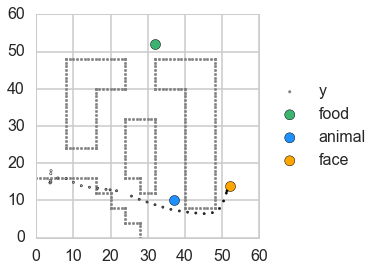

In [10]:
def plot_sub(subj, env, test_trial, rep):
    plot_paths(env=env, subj=subj, 
               dp=df_in.loc[(df_in['type'] == test_trial) &
                            (df_in.rep == rep)], 
               proj=proj, dirs=dirs)
    
subj_opts = ipywidgets.Select(options=list(df_in.subid.unique()))
env_opts = ipywidgets.ToggleButtons(options=list(np.sort(df_in.env.unique())))
test_opts = ipywidgets.ToggleButtons(options=list(['habit', 'shortcut']))
rep_opts = ipywidgets.IntSlider(min=1, max=2)

w = ipywidgets.interact(plot_sub, 
                        subj=subj_opts, 
                        env=env_opts, 
                        test_trial=test_opts, 
                        rep=rep_opts)

- 20: has 3 reps of envs 4-6, and doesn't have 2nd rep of envs 10-12
- 40 (habit, env3): loops around too many times, and wrong env? [looks like ran through envs 4,5,3, crashed on 3, and then restarted to run through 5 and 3 again. Removed run 3 from first log file, and run 5 from 2nd log file (but keep beginning of log file to have write number of cols)]
- 38 
    - (shortcut 1, env8, 9): wrong map? [appears to be env7 run partway through, then restarted and ran again -- moved the initial env7 to main sst38 folder, append run_5 to start]
    - (shortcut 1, env7): didn't end?
    - (habit, env11, env6): wrong env? [town 7 was repeated twice, so moved first iteration log file/dir out into main sst38 folder, append run_4 to start]